# Notebook demo of using vqe module to solve a QUBO

In [1]:
import sys
sys.path.append('../')

from aquapointer.digital.loaddata import LoadData
from aquapointer.digital.qubo import Qubo
import aquapointer.digital.qubo_utils as qutils
from aquapointer.digital.vqe import VQE

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class
from qiskit.circuit.library import QAOAAnsatz
from qiskit.primitives import Sampler
from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')
sampler = Sampler(options={"shots": int(1e4)})

In [2]:
# LoadData does all the file loading
ld = LoadData()

# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from LoadData.
q = Qubo(ld)

In [3]:
# use the first slice as an example to solve
qubo, ising_ham = q.qubo_hamiltonian_pairs[0]
num_qubits = len(qubo)

# QAOA ansatz circuit
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

from qiskit.circuit.library import TwoLocal
# TwoLocal ansatz circuit
twolocal_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
qubo

array([[-0.01074377,  0.04727714,  0.04727714,  0.04727714],
       [ 0.04727714, -0.00892812,  0.03218907,  0.04727714],
       [ 0.04727714,  0.03218907, -0.00865155,  0.04727714],
       [ 0.04727714,  0.04727714,  0.04727714, -0.00969204]])

In [148]:
def top_average_energy(vqe_object: VQE, alpha: float, maxiter: int, fraction: float, verbose=False):

    res = vqe_object.run(alpha=alpha, maxiter=maxiter, method='COBYLA')

    # Assign solution parameters to ansatz
    qc = vqe_object.ansatz.assign_parameters(vqe_object.params)
    # Add measurements to our circuit
    qc.measure_all()
    # Sample ansatz at optimal parameters
    samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
    samp_dist_binary = samp_dist.binary_probabilities()

    correct_dist = {}
    for key in samp_dist_binary.keys():
        reverse_key = key[::-1]
        keynot = [(int(b)+1)%2 for b in reverse_key]
        correct_dist[''.join(map(str, keynot))] = samp_dist_binary[key]

    prob_energy = []
    bitstrings = []
    for key in correct_dist.keys():
        key_np = np.fromiter(map(int, key), dtype=int)
        prob_energy.append([correct_dist[key], qutils.ising_energy(key_np, qubo)])
        bitstrings.append(key)

    bitstrings = np.array(bitstrings)
    prob_energy = np.array(prob_energy)

    sorted_indices = np.argsort(prob_energy[:, 1])
    sorted_keys = bitstrings[sorted_indices]
    sorted_values = prob_energy[:, 1][sorted_indices]

    opt_energy = sorted_values[0]
    opt_b = sorted_keys[0]
    
    #pick top 10% of lowest observed energies and compute probability mass on them
    n = int(len(prob_energy)*fraction)
    if verbose:
        if n<=1:
            print(prob_energy)

    total_mass = 0.0
    top_avg_energy = 0.0
    for i in range(n):
        total_mass += correct_dist[sorted_keys[i]]
        top_avg_energy += sorted_values[i]*correct_dist[sorted_keys[i]]
        if verbose:
            print(sorted_values[i], correct_dist[sorted_keys[i]])
    top_avg_energy = top_avg_energy / total_mass
    return round(top_avg_energy, 5), round(total_mass, 3), (opt_b, opt_energy)  

In [149]:
# run the optimization for a given vqe_object and a list of confidence intervals
def run_optimization(vqe_object, alphas, maxiter):  
    opt_energy = np.inf

    for alpha in alphas:
        top_avg_energy, total_mass, opt = top_average_energy(vqe_object, alpha, maxiter, 0.2, verbose=False)
        if opt_energy>opt[1]:
            opt_energy = opt[1]
            res = opt
            print(opt)
        print(f"{alpha}, {top_avg_energy}, {total_mass}")
    return res

# run the optimization for a given vqe_object and a list of confidence intervals
def run_optimization_prob_opt_sol(vqe_object, alphas, maxiter, verbose=False):
    for alpha in alphas:
        vqe_object.run(alpha, maxiter)
    if verbose:
        print(vqe_object.history)

#helper function to get number of basis gates used in ansatz
def total_gates(ansatz):
    basis_gates=['u1', 'u2', 'u3', 'cx']

    ansatz_transpiled = transpile(ansatz, backend, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=2)
    gates = ansatz_transpiled.count_ops()
    depth = ansatz_transpiled.depth()
    num_params = ansatz.num_parameters

    total_gates = 0
    for gate in basis_gates:
        total_gates += gates.get(gate, 0)
    return total_gates, depth, num_params

In [150]:
# EXAMPLE: QAQA

alphas = [1.0, 0.75, 0.5, 0.25, 0.1]
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)

nfevs_qaoa = run_optimization(vqe_qaoa, alphas, maxiter=20)

('00010000', -0.02404680978135616)
1.0, 0.03788, 0.193
0.75, 0.00878, 0.732
0.5, 0.00588, 0.816
0.25, -0.00605, 0.901
0.1, -0.00622, 0.9


In [10]:
#EXAMPLE: linear entanglement ansatz

vqe_linear = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=np.zeros(0))
alphas = [1.0, 0.75, 0.5, 0.25, 0.1]

nfevs_linear = run_optimization(vqe_linear, alphas, maxiter=60)

('1000', -0.010743767178636635)
1.0, -0.00941, 0.192
0.75, -0.00966, 0.782
0.5, -0.00975, 0.5
0.25, -0.01057, 0.365
0.1, -0.01055, 0.365


# Resource estimation/performance

In [11]:
# depth * number_of_params * maxiter is the same for both approaches, this makes a fair comparison in performance

In [12]:
# EXAMPLE: QAQA

alphas = [1.0, 0.75, 0.5, 0.25, 0.1]
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)

vqe_qaoa.run(alpha=0.9, maxiter=10)
vqe_qaoa.history

[['1000', 0.0602, -0.010743767178636635],
 ['1000', 0.0634, -0.010743767178636635],
 ['1000', 0.0476, -0.010743767178636635],
 ['1000', 0.0741, -0.010743767178636635],
 ['1000', 0.0886, -0.010743767178636635],
 ['1000', 0.1052, -0.010743767178636635],
 ['1000', 0.063, -0.010743767178636635],
 ['1000', 0.0327, -0.010743767178636635],
 ['1000', 0.0584, -0.010743767178636635],
 ['1000', 0.1062, -0.010743767178636635]]

In [13]:
# let us first list the optimal solutions for the qubo problems using the classical brute force approach
optimal_solutions = []

for qubo in q.qubo_hamiltonian_pairs:
    # classical brute-force solution
    solution = q.find_optimum(qubo=qubo[0])
    optimal_solutions.append(solution)

optimal_solutions

[('1000', -0.010743767178636635),
 ('010000001', -0.05676551209085727),
 ('10001000000001', -0.07861404665042948),
 ('10000000100100', -0.07111143020268126),
 ('0000010100000', -0.05195638819992217),
 ('00010000', -0.02404680978135616)]

In [168]:
np.random.seed(0)
import time

# now we solve all the qubo's and output optimal bitstrings of for each slice using QAOA and twolocal ansatz
alphas = [0.95]
maxiter = 20


res_qaoa_slices = []
res_linear_slices = []

i = 0

num_mc = 40

for qubo, ising_ham in q.qubo_hamiltonian_pairs:
    num_qubits = len(qubo)
    opt_sol = optimal_solutions[i]
    res_qaoa = []
    res_linear = []
    print(f"slice {i}")
    i+=1
    
    # define the ansatzes
    qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)
    beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
    gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
    params_qaoa = np.array(beta+gamma)

    # TwoLocal ansatz circuit
    twolocal_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
    params_linear = np.array([np.random.random()]*twolocal_ansatz.num_parameters)

    # to keep it fair, we want depth * number_of_params * maxiter to be the same for both instances
    resources_qaoa, resources_twolocal = total_gates(qaoa_ansatz), total_gates(twolocal_ansatz)
    iter_factor = (resources_qaoa[1]/resources_twolocal[1]) * (resources_qaoa[2]/resources_twolocal[2])
    maxiter_qaoa = maxiter
    maxiter_linear = int(maxiter_qaoa * iter_factor)

    histories_qaoa = []
    histories_linear = []

    start=time.time()
    vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params_qaoa)
    for _ in range(num_mc):
        vqe_qaoa.params = params_qaoa
        vqe_qaoa.history = []

        res = run_optimization_prob_opt_sol(vqe_qaoa, alphas, maxiter=maxiter_qaoa)
        histories_qaoa.append(vqe_qaoa.history)
    end=time.time()
    print(f'time elapsed for QAOA: {end-start}')

    start=time.time()
    vqe_linear = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=params_linear)
    for _ in range(num_mc):
        vqe_linear.params = params_linear
        vqe_linear.history = []

        res = run_optimization_prob_opt_sol(vqe_linear, alphas, maxiter=maxiter_linear)
        histories_linear.append(vqe_linear.history)
    end=time.time()
    print(f'time elapsed for LE: {end-start}')

    res_qaoa_slices.append(histories_qaoa)
    res_linear_slices.append(histories_linear)

slice 0
time elapsed for QAOA: 3.590859889984131
time elapsed for LE: 2.6745550632476807
slice 1
time elapsed for QAOA: 16.672847032546997
time elapsed for LE: 10.203205108642578
slice 2
time elapsed for QAOA: 622.590441942215
time elapsed for LE: 437.4176502227783
slice 3
time elapsed for QAOA: 285.75106287002563
time elapsed for LE: 419.2083990573883
slice 4
time elapsed for QAOA: 113.29045414924622
time elapsed for LE: 144.260812997818
slice 5
time elapsed for QAOA: 12.028142929077148
time elapsed for LE: 6.883942365646362


In [169]:
# extract the probability of optimal solution from the history of the vqe objects
prob_opt_sol_qaoa = []

for slice in range(6):
    probs_perslice = np.zeros((num_mc, len(res_qaoa_slices[slice][0])))
    for i in range(num_mc):
        for j in range(len(res_qaoa_slices[slice][i])):
            if res_qaoa_slices[slice][i][j][0] == optimal_solutions[slice][0]:
                probs_perslice[i][j] = res_qaoa_slices[slice][i][j][1]

    prob_opt_sol_qaoa.append(probs_perslice)

prob_opt_sol_linear = []

for slice in range(6):
    probs_perslice = np.zeros((num_mc, len(res_linear_slices[slice][0])))
    for i in range(num_mc):
        for j in range(len(res_linear_slices[slice][i])):
            if res_linear_slices[slice][i][j][0] == optimal_solutions[slice][0]:
                probs_perslice[i][j] = res_linear_slices[slice][i][j][1]

    prob_opt_sol_linear.append(probs_perslice)


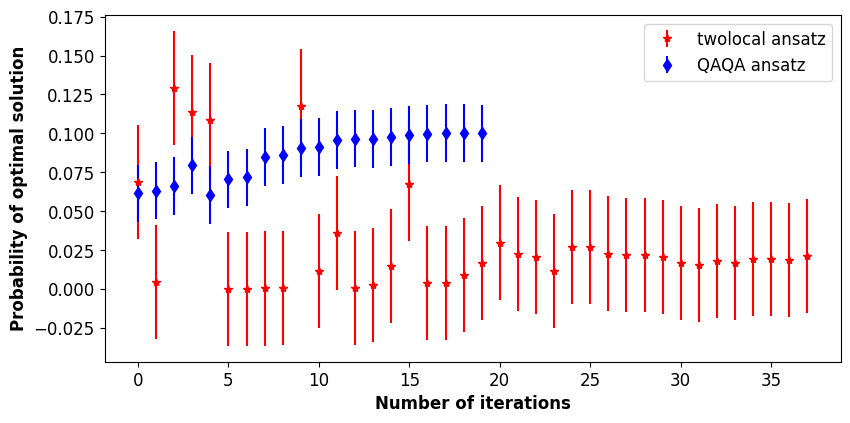

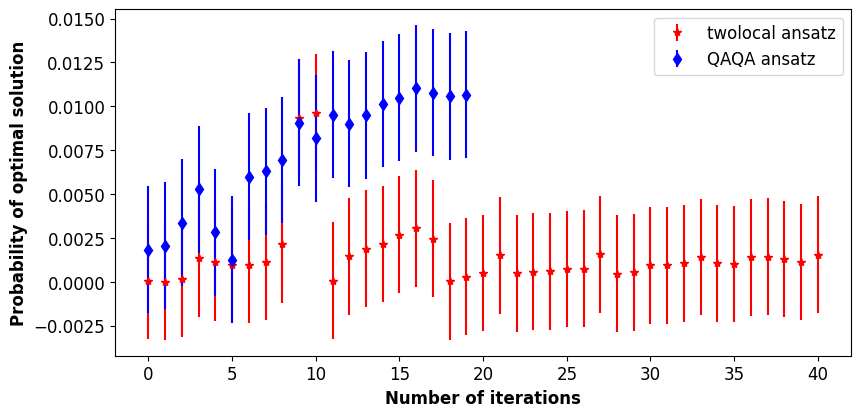

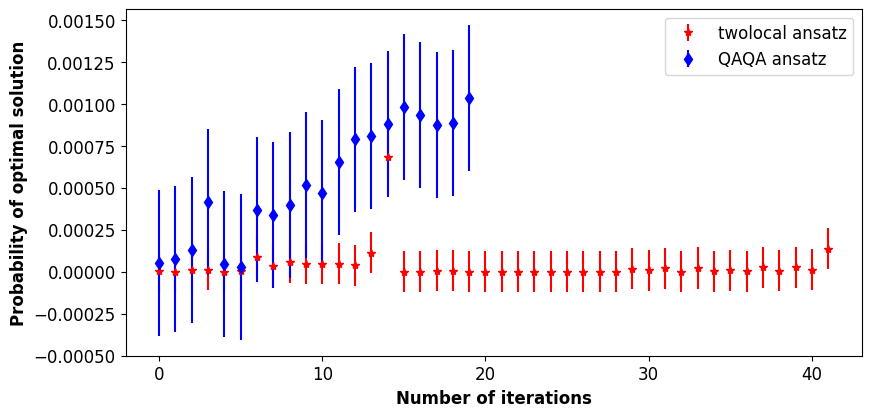

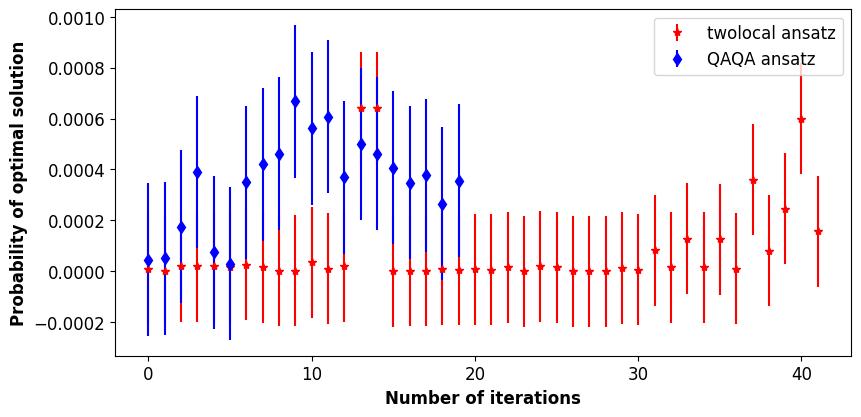

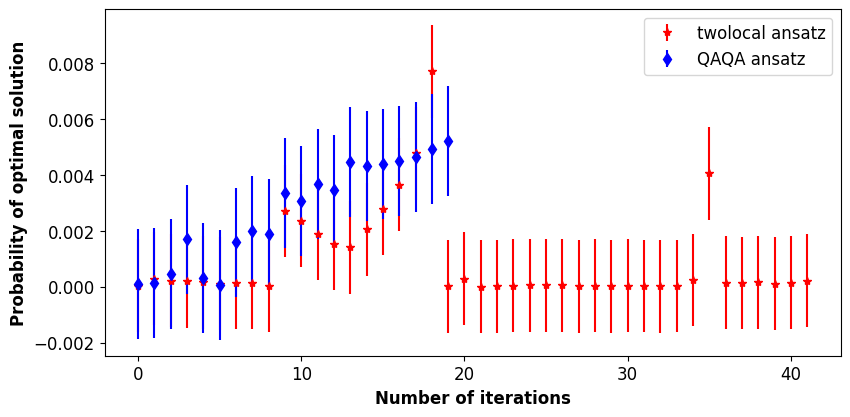

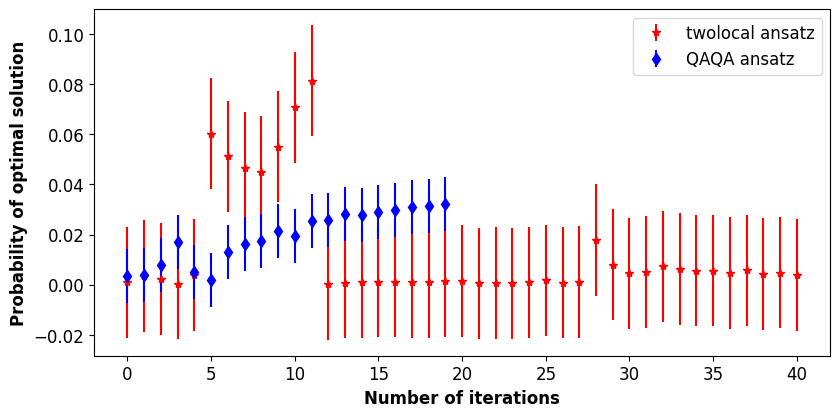

In [170]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

for slice in range(6):
    # slice = 5
    number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa[slice][0])))
    number_of_iterations_linear = list(range(len(prob_opt_sol_linear[slice][0])))
    errorbar_linear = np.std(prob_opt_sol_linear[slice])
    errorbar_qaoa = np.std(prob_opt_sol_qaoa[slice])

    plt.figure()
    # plt.plot(number_of_iterations, np.mean(np.array(res_linear_slices[slice]), axis=1), '*r', label='twolocal ansatz')
    plt.errorbar(number_of_iterations_linear, np.mean(prob_opt_sol_linear[slice], axis=0), yerr=errorbar_linear, fmt='*r', label='twolocal ansatz')
    plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa[slice], axis=0), yerr=errorbar_qaoa, fmt='db', label='QAQA ansatz')
    plt.legend()
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')
